## Demo notebook for accessing NAIP data on Azure

This notebook provides an example of accessing NAIP data from blob storage on Azure, displaying an image using the [rasterio](https://github.com/mapbox/rasterio) library.  

We will demonstrate how to access and plot a tile given a known tile filename, as well as how to access tiles by lat/lon.  Finally, we'll demonstrate how to retrieve only the patches you care about from our cloud-optimized image files.

NAIP data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on NAIP data also be situated in West Europe.  You don't want to download hundreds of terabytes to your laptop!  If you are using NAIP data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports and environment

In [1]:
# Standard packages
import tempfile
import warnings
import urllib
import shutil
import os

# Less standard, but still pip- or conda-installable
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import re
import rtree
import shapely
import pickle

# pip install progressbar2, not progressbar
import progressbar

from geopy.geocoders import Nominatim
from rasterio.windows import Window 
from tqdm import tqdm

latest_wkid = 3857
crs = "EPSG:4326"

# Storage locations are documented at http://aka.ms/ai4edata-naip

# The(preferred) copy of NAIP in the West Europe Azure region
blob_root = 'https://naipeuwest.blob.core.windows.net/naip'

# NAIP is also available in the East US Azure region
# blob_root = 'https://naipblobs.blob.core.windows.net/naip'

index_files = ["tile_index.dat", "tile_index.idx", "tiles.p"]
index_blob_root = re.sub('/naip$','/naip-index/rtree/',blob_root)
temp_dir = os.path.join(tempfile.gettempdir(),'naip')
os.makedirs(temp_dir,exist_ok=True)

# Spatial index that maps lat/lon to NAIP tiles; we'll load this when we first 
# need to access it.
index = None

# URL where we've stashed a geojson file with the boundaries of Maryland.  Why do we
# need the boundaries of Maryland?  It's a surprise, you'll have to keep reading to find
# out.
maryland_boundary_url = 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/maryland.json'

warnings.filterwarnings("ignore")

### Functions

In [2]:
class DownloadProgressBar():
    """
    https://stackoverflow.com/questions/37748105/how-to-use-progressbar-module-with-urlretrieve
    """
    
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(max_value=total_size)
            self.pbar.start()
            
        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()
            

class NAIPTileIndex:
    """
    Utility class for performing NAIP tile lookups by location.
    """
    
    tile_rtree = None
    tile_index = None
    base_path = None
    
    def __init__(self, base_path=None):
        
        if base_path is None:
            
            base_path = temp_dir
            os.makedirs(base_path,exist_ok=True)
            
            for file_path in index_files:
                download_url(index_blob_root + file_path, base_path + '/' + file_path,
                             progress_updater=DownloadProgressBar())
                
        self.base_path = base_path
        self.tile_rtree = rtree.index.Index(base_path + "/tile_index")
        self.tile_index = pickle.load(open(base_path  + "/tiles.p", "rb"))
      
    
    def lookup_tile(self, lat, lon):
        """"
        Given a lat/lon coordinate pair, return the list of NAIP tiles that contain
        that location.

        Returns a list of COG file paths.
        """

        point = shapely.geometry.Point(float(lon),float(lat))
        intersected_indices = list(self.tile_rtree.intersection(point.bounds))

        intersected_files = []
        tile_intersection = False

        for idx in intersected_indices:

            intersected_file = self.tile_index[idx][0]
            intersected_geom = self.tile_index[idx][1]
            if intersected_geom.contains(point):
                tile_intersection = True
                intersected_files.append(intersected_file)

        if not tile_intersection and len(intersected_indices) > 0:
            print('''Error: there are overlaps with tile index, 
                      but no tile completely contains selection''')   
            return None
        elif len(intersected_files) <= 0:
            print("No tile intersections")
            return None
        else:
            return intersected_files
        
            
def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')    
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url)))
        return destination_filename
    print('Downloading file {} to {}'.format(os.path.basename(url),destination_filename),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename
    

def display_naip_tile(filename):
    """
    Display a NAIP tile using rasterio.
    """
    
    # NAIP tiles are enormous; downsize for plotting in this notebook
    dsfactor = 10
    
    with rasterio.open(filename) as raster:

        # NAIP imagery has four channels: R, G, B, IR
        #
        # Stack RGB channels into an image; we won't try to render the IR channel
        #
        # rasterio uses 1-based indexing for channels.
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        print('Resampling to {},{}'.format(h,w))
        r = raster.read(1, out_shape=(1, h, w))
        g = raster.read(2, out_shape=(1, h, w))
        b = raster.read(3, out_shape=(1, h, w))        
    
    rgb = np.dstack((r,g,b))
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100, edgecolor='k')
    plt.imshow(rgb)
    raster.close()
    
    
def get_coordinates_from_address(address):
    """
    Look up the lat/lon coordinates for an address.
    """
    
    geolocator = Nominatim(user_agent="NAIP")
    location = geolocator.geocode(address)
    print('Retrieving location for address:\n{}'.format(location.address))
    return location.latitude, location.longitude

### Access and plot a NAIP tile by constructing a path

https://naipeuwest.blob.core.windows.net/naip/v002/al/2015/al_100cm_2015/30086/m_3008601_ne_16_1_20150804.tif

100% (235499681 of 235499681) |##########| 


...done, 235499681 bytes.
Reading file:
https_naipeuwest.blob.core.windows.net_naip_v002_al_2015_al_100cm_2015_30086_m_3008601_ne_16_1_20150804.tif
Resampling to 753,657


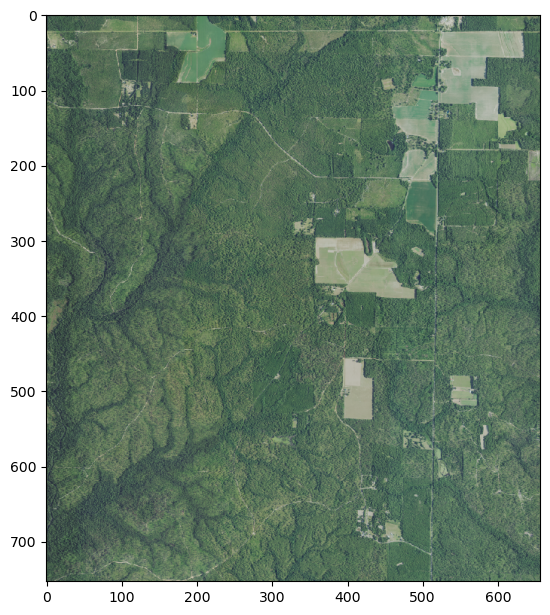

In [3]:
# Tiles are stored at:
#
# [blob root]/v002/[state]/[year]/[state]_[resolution]_[year]/[quadrangle]/filename

year = '2015'
state = 'al'
resolution = '100cm'
quadrangle = '30086'
filename = 'm_3008601_ne_16_1_20150804.tif'
tile_url = blob_root + '/v002/' + state + '/' + year + '/' + state + '_' + resolution + \
    '_' + year + '/' + quadrangle + '/' + filename

print(tile_url)

# Download the image
image_filename = download_url(tile_url)

# Plot the image
print('Reading file:\n{}'.format(os.path.basename(image_filename)))
assert os.path.isfile(image_filename)
display_naip_tile(image_filename)

### Load the spatial index of NAIP tiles

In [4]:
if index is None:
    index = NAIPTileIndex()

100% (82944000 of 82944000) |############| 


...done, 82944000 bytes.

100% (445652 of 445652) |################| 


...done, 445652 bytes.

100% (178955434 of 178955434) |##########| 


...done, 178955434 bytes.


### Access and plot a NAIP tile based on a lat/lon coordinate pair


List of available naip files for this location:

v002/wa/2011/wa_100cm_2011/47122/m_4712223_se_10_1_20110826.tif
v002/wa/2013/wa_100cm_2013/47122/m_4712223_se_10_1_20130910.tif
v002/wa/2015/wa_100cm_2015/47122/m_4712223_se_10_1_20150825.tif
v002/wa/2017/wa_100cm_2017/47122/m_4712223_se_10_1_20170815.tif
v002/wa/2019/wa_60cm_2019/47122/m_4712223_se_10_060_20191011.tif


100% (496121654 of 496121654) |##########| 


...done, 496121654 bytes.
Resampling to 1234,862


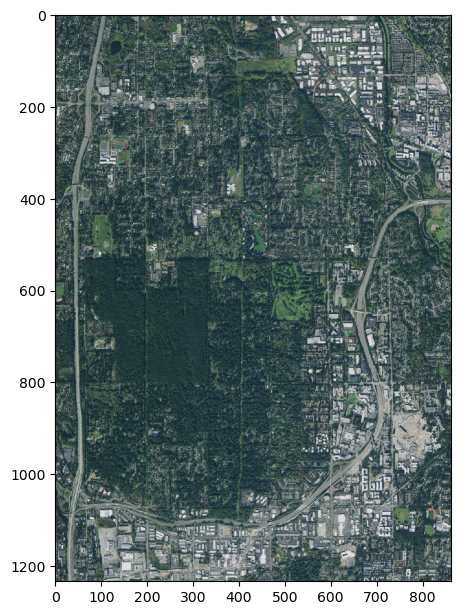

In [5]:
lat = 47.645950
lon = -122.136980

naip_files = index.lookup_tile(lat, lon)

print('\nList of available naip files for this location:\n')
for file in naip_files:
    print(file)
print('')

# Choose the latest NAIP tile from this location
#
# Images are indexed in reverse-chronological order, so zero is the
# most recent image.
image_filename = download_url(blob_root + '/' + naip_files[-1])

# Render this tile
display_naip_tile(image_filename)

### Access and plot a NAIP tile based on an address

Retrieving location for address:
Microsoft Mixer, 15255, Northeast 40th Street, Microsoft West Campus, Redmond, King County, Washington, 98052, United States

Finding tiles for (47.64433175,-122.13645425466683)

List of available naip tiles:

v002/wa/2011/wa_100cm_2011/47122/m_4712223_se_10_1_20110826.tif
v002/wa/2013/wa_100cm_2013/47122/m_4712223_se_10_1_20130910.tif
v002/wa/2015/wa_100cm_2015/47122/m_4712223_se_10_1_20150825.tif
v002/wa/2017/wa_100cm_2017/47122/m_4712223_se_10_1_20170815.tif
v002/wa/2019/wa_60cm_2019/47122/m_4712223_se_10_060_20191011.tif

Latest naip tile for location...

v002/wa/2019/wa_60cm_2019/47122/m_4712223_se_10_060_20191011.tif

Bypassing download of already-downloaded file m_4712223_se_10_060_20191011.tif

Plotting latest NAIP tile for location...
Resampling to 1234,862


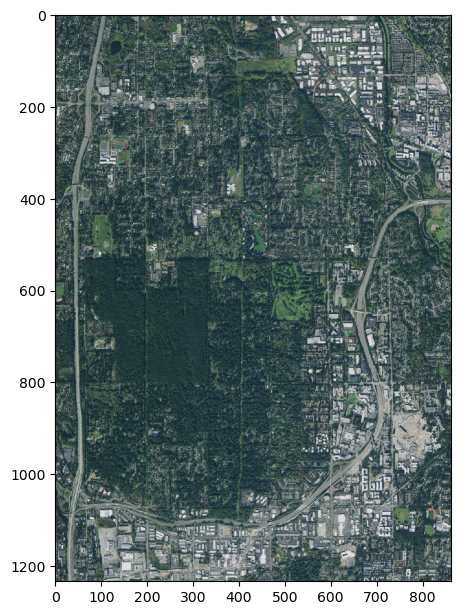

In [6]:
# Get latitude and longitude for location
address = '15255 NE 40th St, Redmond, WA 98052'
lat,lon = get_coordinates_from_address(str(address))

print('\nFinding tiles for ({},{})'.format(lat,lon))
naip_files = index.lookup_tile(lat,lon)

print('\nList of available naip tiles:\n')
for file in naip_files:
    print(file)

print('\nLatest naip tile for location...\n')
print(naip_files[-1] + '\n')

image_filename = download_url(blob_root + '/' + naip_files[-1],
                              progress_updater=DownloadProgressBar())

print('\nPlotting latest NAIP tile for location...')
display_naip_tile(image_filename)

### Sampling patches from cloud-optimized GeoTIFFs

Imagine we want to sparsely sample 256x256 patches of NAIP imagery from 2017 over the entire state of Maryland - we *definitely* wouldn't want to download the 901 tiles, or 171 GB of imagery up front! At a standard 30 megabits/second download speed this would take ~12 hours, and even at a 30 megaBYTES/second download speed, it would take 30 minutes. If we just want 100 patches then we want to download data for, 100 * 256 * 256 = 6,553,600 pixels. At 4 channels per pixel and 1 byte per channel, this comes out to ~26 MB, uncompressed, a tiny fraction of the size of the entire state.

Thankfully, the NAIP imagery in Azure Open Datasets is stored as [Cloud Optimized GeoTIFFs](https://www.cogeo.org), which means that it is simple to just download the parts we want over HTTP(S).

Below is an example of how to do this with the [`rasterio` package](https://github.com/mapbox/rasterio).

#### Sample our patches

In [7]:
import fiona
import fiona.transform
import requests
import json

# Define the boundaries of our query (the state of Maryland)
maryland_geojson = json.loads(requests.get(maryland_boundary_url).text)
maryland_shape = shapely.geometry.shape(maryland_geojson)

# Until we have 100 points:
#   - Sample a random point from within Maryland's bounding box
#   - Check to see whether it is in Maryland
#   - If it is, keep it, else ignore
points = []

minx, miny, maxx, maxy = maryland_shape.bounds
while len(points) < 100:
    x = np.random.uniform(minx, maxx)
    y = np.random.uniform(miny, maxy)
    
    if maryland_shape.contains(shapely.geometry.Point(x,y)):
        points.append((x,y))
        
image_crops = [] # place to save the images we grab
image_points = [] # place to save the lat/lons

for i, point in enumerate(points):
    
    lon, lat = point
    
    # Find the filenames that intersect with our lat/lon
    naip_files = index.lookup_tile(lat, lon) 

    if naip_files is None or len(naip_files) == 0:
        print('No intersection, skipping point {}'.format(i))
        continue
    
    # We could do some more checking here to make sure that the file is from 2017 Maryland,
    # but that's not the point
    image_url = blob_root + '/' + naip_files[-1] 
    
    with rasterio.open(image_url) as f:
        
        # Each NAIP tile has its own coordinate system that is *not* lat/lon 
        crs = f.crs 
        
        # This object will let us convert between tile coordinates (these will be local
        # state CRS) and tile offsets (i.e. pixel indices)
        transform = f.transform 
        
        # Convert our lat/lon point to the local NAIP coordinate system
        x_tile_crs, y_tile_crs = fiona.transform.transform("epsg:4326", crs.to_string(),
                                                           [lon], [lat]) 
        x_tile_crs = x_tile_crs[0]
        y_tile_crs = y_tile_crs[0]

        # Convert our new x/y coordinates into pixel indices
        x_tile_offset, y_tile_offset = ~transform * (x_tile_crs, y_tile_crs) 
        x_tile_offset = int(np.floor(x_tile_offset))
        y_tile_offset = int(np.floor(y_tile_offset))        
        
        # The secret sauce: only read data from a 256x256 window centered on our point
        image_crop = f.read(window=Window(x_tile_offset-128, y_tile_offset-128, 256, 256)) 
        image_crop = np.rollaxis(image_crop, 0, 3)
        
    # Sometimes our point will be on the edge of a NAIP tile, and our windowed reader above
    # will not actually return a 256x256 chunk of data. We could handle this nicely by going 
    # back up to the `naip_files` list and trying to read from one of the other tiles - 
    # because the NAIP tiles have overlap with one another, there should exist an intersecting
    # tile with the full window.
    if (image_crop.shape[0] == 256) and (image_crop.shape[1] == 256):
        image_crops.append(image_crop)
        image_points.append(point)
    else:
        print('Our crop was likely at the edge of a NAIP tile, skipping point {}'.format(i))

# ...for each point

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [07:21<03:31,  6.21s/it]

Our crop was likely at the edge of a NAIP tile, skipping point 65


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:13<00:00,  6.74s/it]


In [ ]:
print(image_crop.shape)

#### Plot the patches we just retrieved

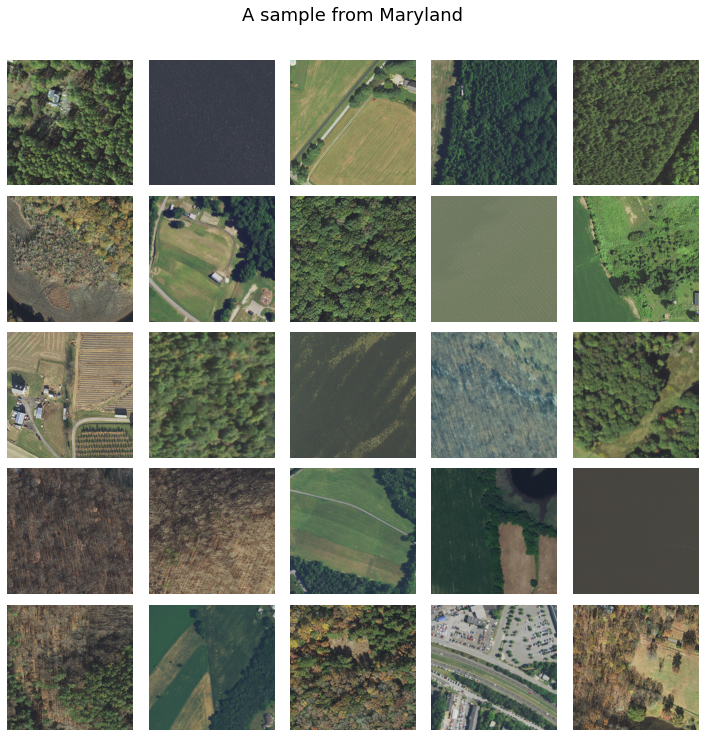

In [8]:
fig, axs = plt.subplots(5, 5, figsize=(10,10), edgecolor='k')
axs = axs.flatten()

for i in range(25):
    axs[i].imshow(image_crops[i][:,:,:3])
    axs[i].axis('off')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].set_aspect('equal')

plt.suptitle('A sample from Maryland', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()
plt.close()

#### Compare to Bing imagery as a double-check

In [9]:
print('Compare the imagery at the following links to the top row of the above image:')
for i in range(5):
    lon, lat = image_points[i]
    print('https://www.bing.com/maps?&cp={}~{}&lvl=19&style=h'.format(lat,lon))

Compare the imagery at the following links to the top row of the above image:
https://www.bing.com/maps?&cp=37.97496471550852~-75.8441022310085&lvl=19&style=h
https://www.bing.com/maps?&cp=38.407935532405~-76.5776794827661&lvl=19&style=h
https://www.bing.com/maps?&cp=39.423217472231265~-77.58431476799642&lvl=19&style=h
https://www.bing.com/maps?&cp=38.63741259309551~-76.65237034246043&lvl=19&style=h
https://www.bing.com/maps?&cp=38.26375347555889~-75.28965039190257&lvl=19&style=h


### Clean up temporary files

In [10]:
del index
shutil.rmtree(temp_dir)